In [38]:
import numpy as np
import os
import datetime
import tensorflow as tf
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


In [47]:
df = pd.read_csv('NormResampled.csv',  parse_dates=['epoch'], index_col='epoch')

train_split = int(len(df)*0.7)
tf.random.set_seed(13)
df = df.loc[:, df.columns != 'Resampled_Index']
df2 = df.values
df.head()

Month sin  Month cos  Position Vector(X)  Position Vector(Y)  \
epoch                                                                      
1998-01-01  -0.517889  -0.855448            0.074463           -0.336016   
1998-01-02   0.780744   0.624852           -0.591520            0.427889   
1998-01-03  -0.948139  -0.317856            0.610163           -0.622133   
1998-01-04   0.999608  -0.028003            0.841198            0.536150   
1998-01-05  -0.928857   0.370439           -0.842137           -0.251300   

            Position Vector(Z)  Velocity Vector(X)  Velocity Vector(Y)  \
epoch                                                                    
1998-01-01            0.938286            0.183894           -0.810099   
1998-01-02            0.684320           -0.496834            0.326404   
1998-01-03            0.253694            0.110463           -0.182723   
1998-01-04           -0.062808           -0.059299           -0.043842   
1998-01-05           -0.479632            0.397476            0.097735   

            Velocity Vector(Z)  
epoch                           
1998-01-01           -0.291015  
1998-01-02           -0.618844  
1998-01-03           -0.822229  
1998-01-04           -0.854095  
1998-01-05           -0.755121

In [48]:
features_considered = ['Month sin','Month cos','Position Vector(X)', 'Position Vector(Y)','Position Vector(Z)','Velocity Vector(X)','Velocity Vector(Y)', 'Velocity Vector(Z)']

features = df[features_considered]
features.index = df.index
features.head()

Month sin  Month cos  Position Vector(X)  Position Vector(Y)  \
epoch                                                                      
1998-01-01  -0.517889  -0.855448            0.074463           -0.336016   
1998-01-02   0.780744   0.624852           -0.591520            0.427889   
1998-01-03  -0.948139  -0.317856            0.610163           -0.622133   
1998-01-04   0.999608  -0.028003            0.841198            0.536150   
1998-01-05  -0.928857   0.370439           -0.842137           -0.251300   

            Position Vector(Z)  Velocity Vector(X)  Velocity Vector(Y)  \
epoch                                                                    
1998-01-01            0.938286            0.183894           -0.810099   
1998-01-02            0.684320           -0.496834            0.326404   
1998-01-03            0.253694            0.110463           -0.182723   
1998-01-04           -0.062808           -0.059299           -0.043842   
1998-01-05           -0.479632            0.397476            0.097735   

            Velocity Vector(Z)  
epoch                           
1998-01-01           -0.291015  
1998-01-02           -0.618844  
1998-01-03           -0.822229  
1998-01-04           -0.854095  
1998-01-05           -0.755121

In [53]:
features.columns[:3]

Index(['Month sin', 'Month cos', 'Position Vector(X)'], dtype='object')

In [40]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data)[:,:,:,np.newaxis,np.newaxis], np.array(labels)[:,:,:,np.newaxis,np.newaxis]

In [41]:

history = 120
future_target = 15
STEP = 1
x_train_multi, y_train_multi = multivariate_data(df2, df2[:,[2,3,4,5,6,7]], 0, train_split, history,
                                                  future_target, STEP)

x_val_multi, y_val_multi = multivariate_data(df2, df2[:,[2,3,4,5,6,7]], train_split, None, history,
                                               future_target, STEP)

In [43]:
batch_size = 96                                             
buffer_size = 10000
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(batch_size).repeat()


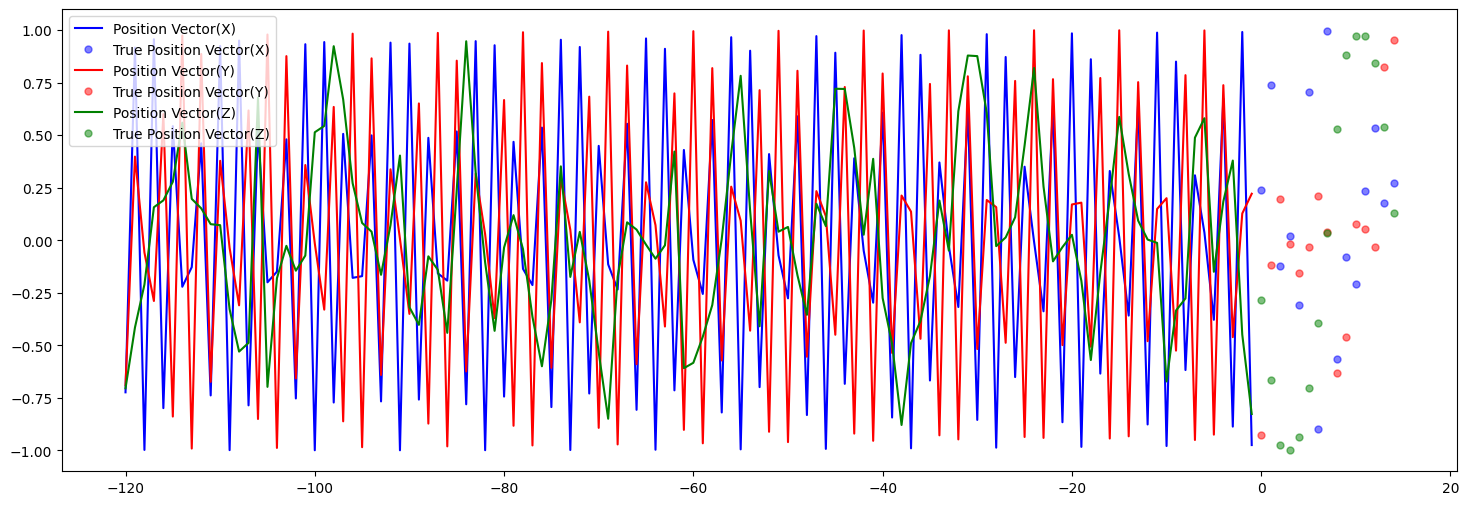

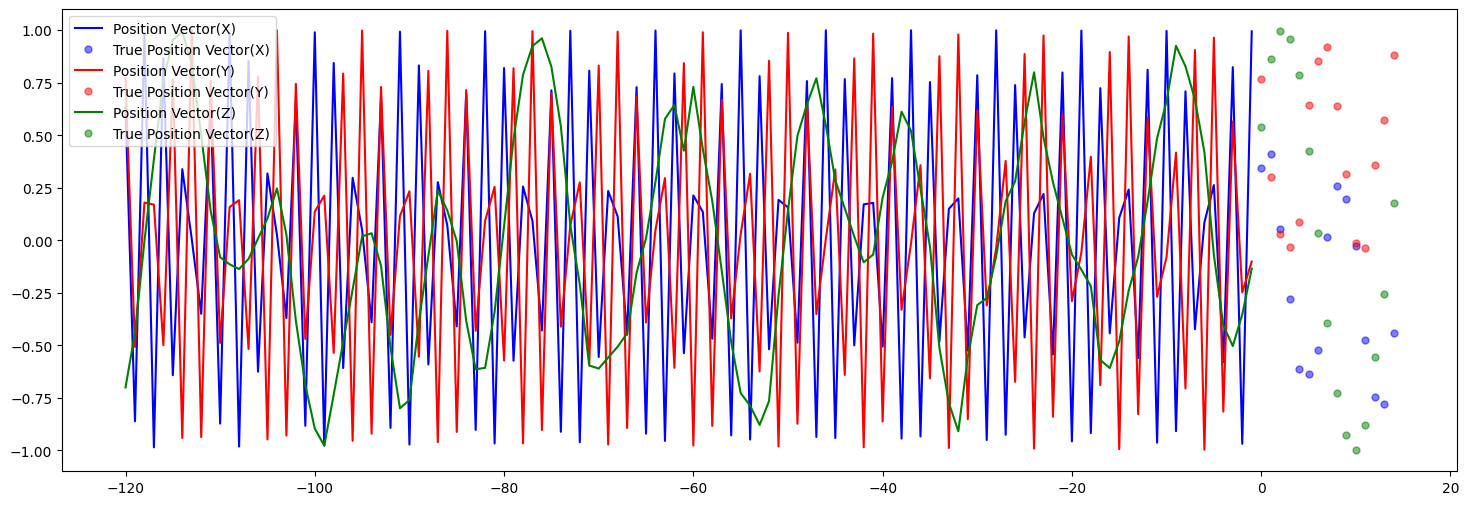

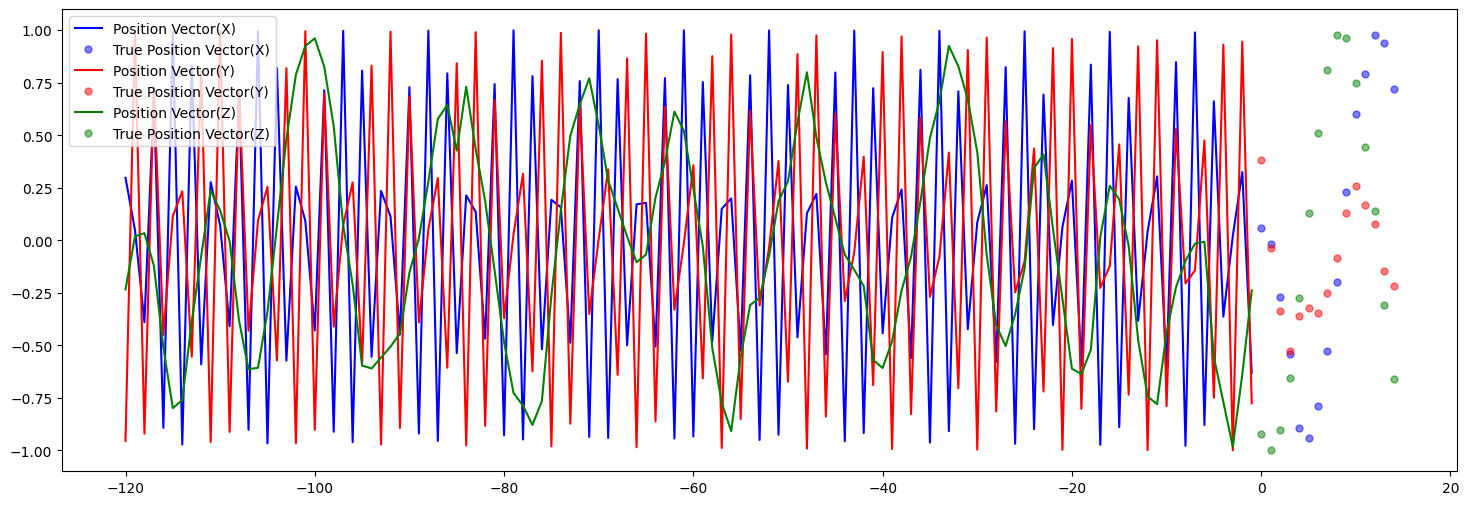

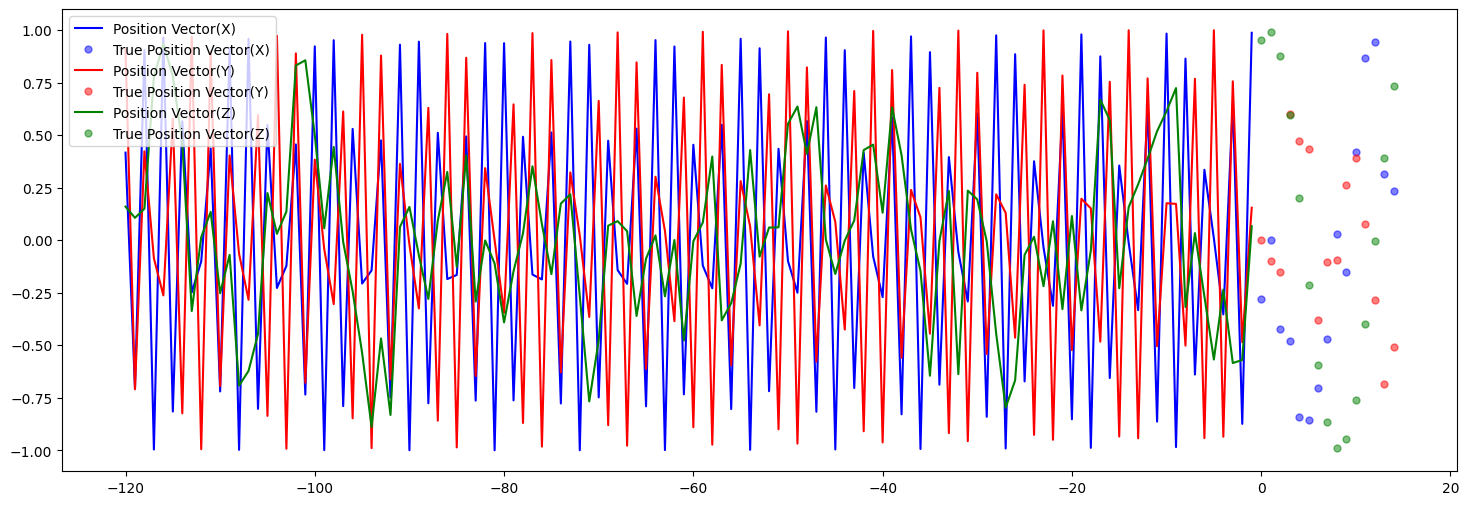

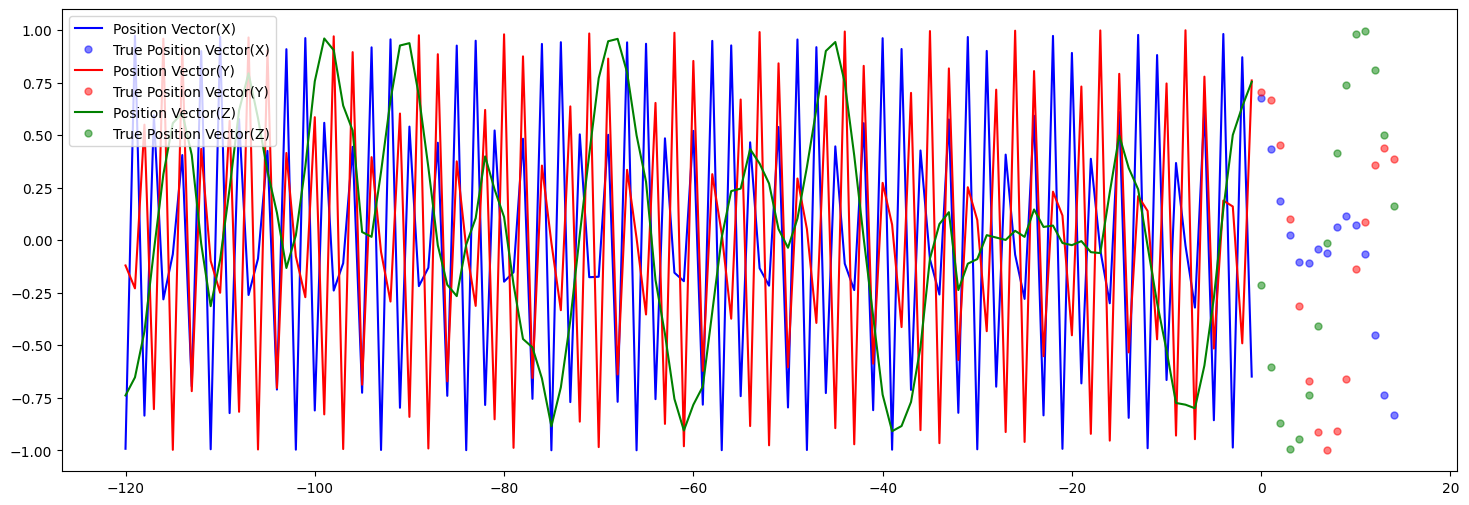

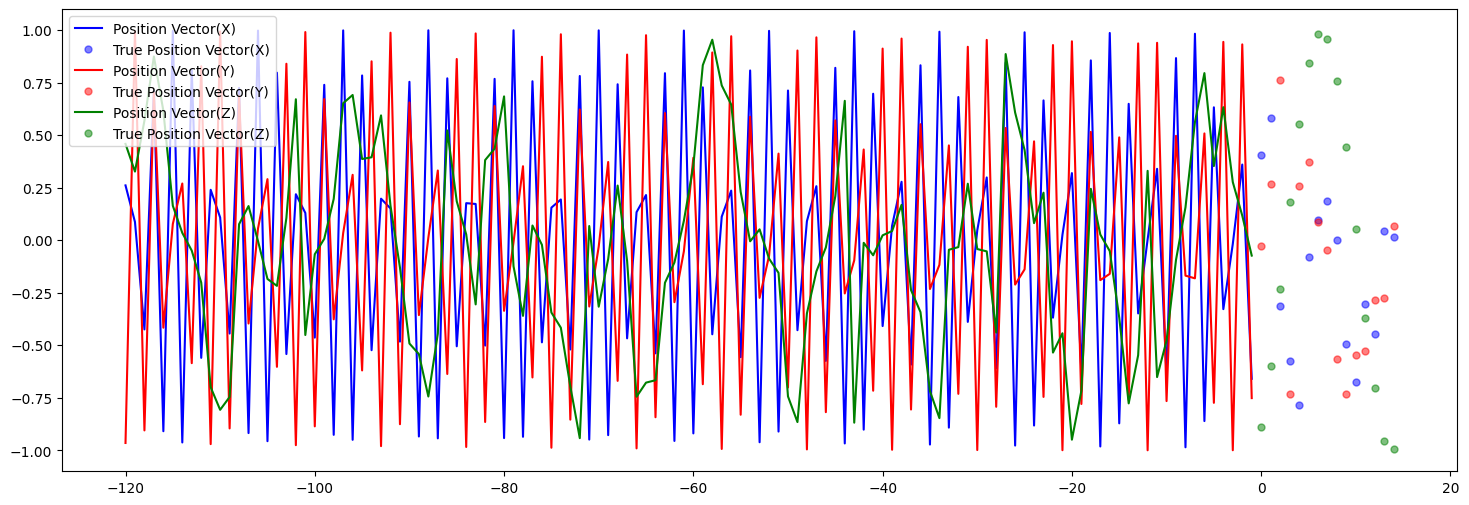

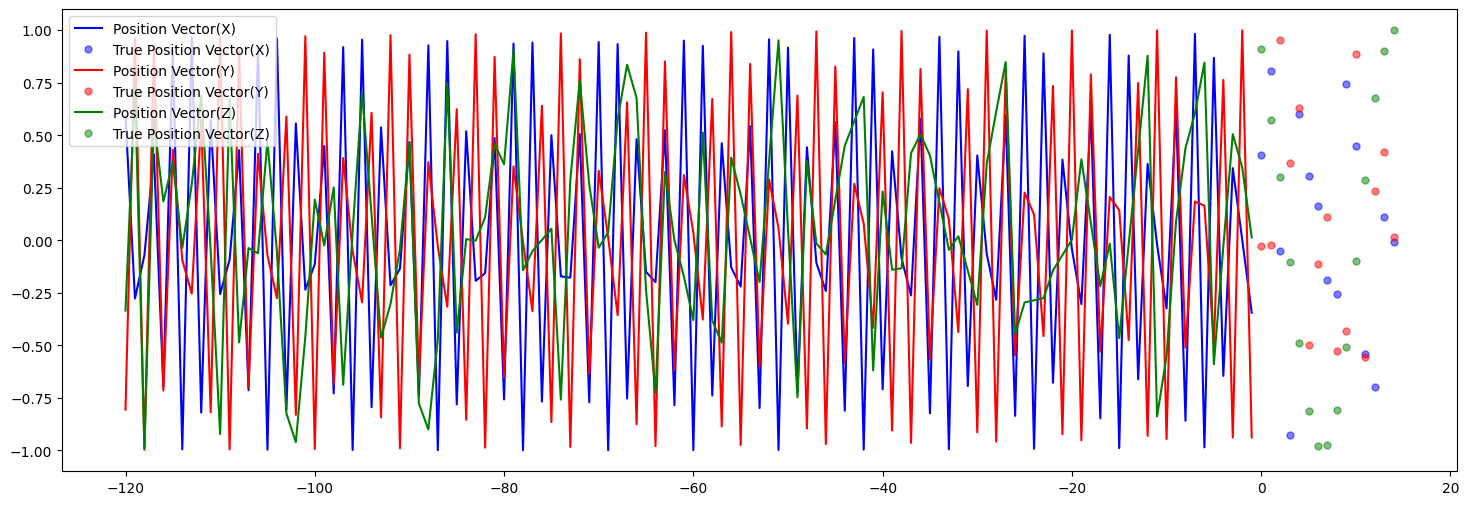

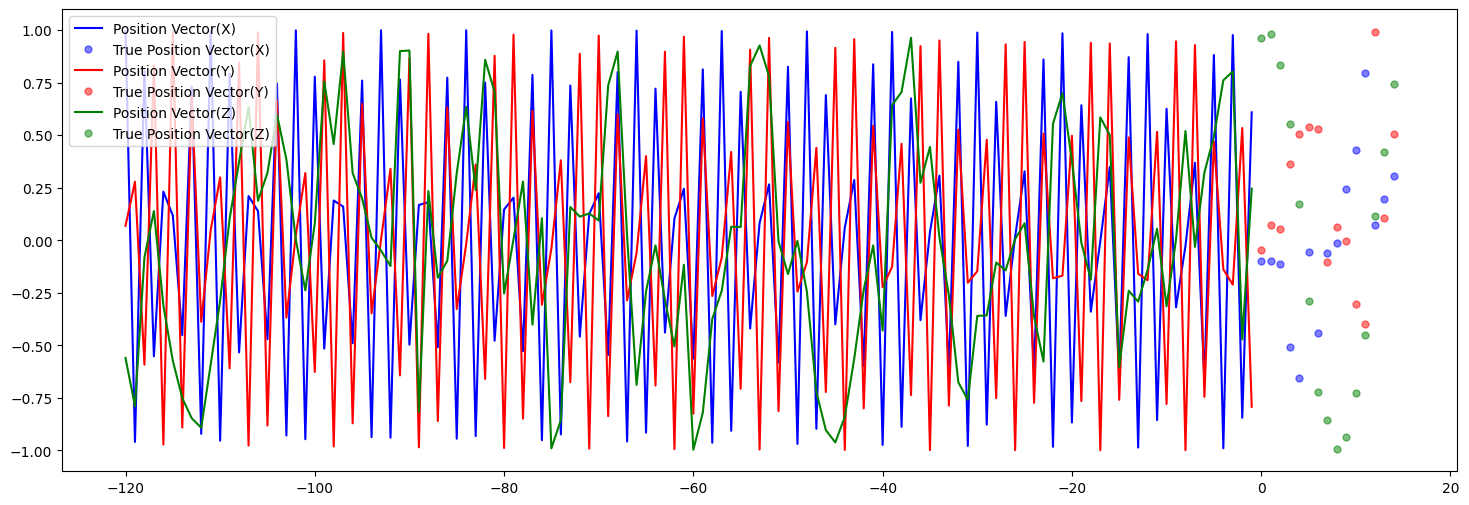

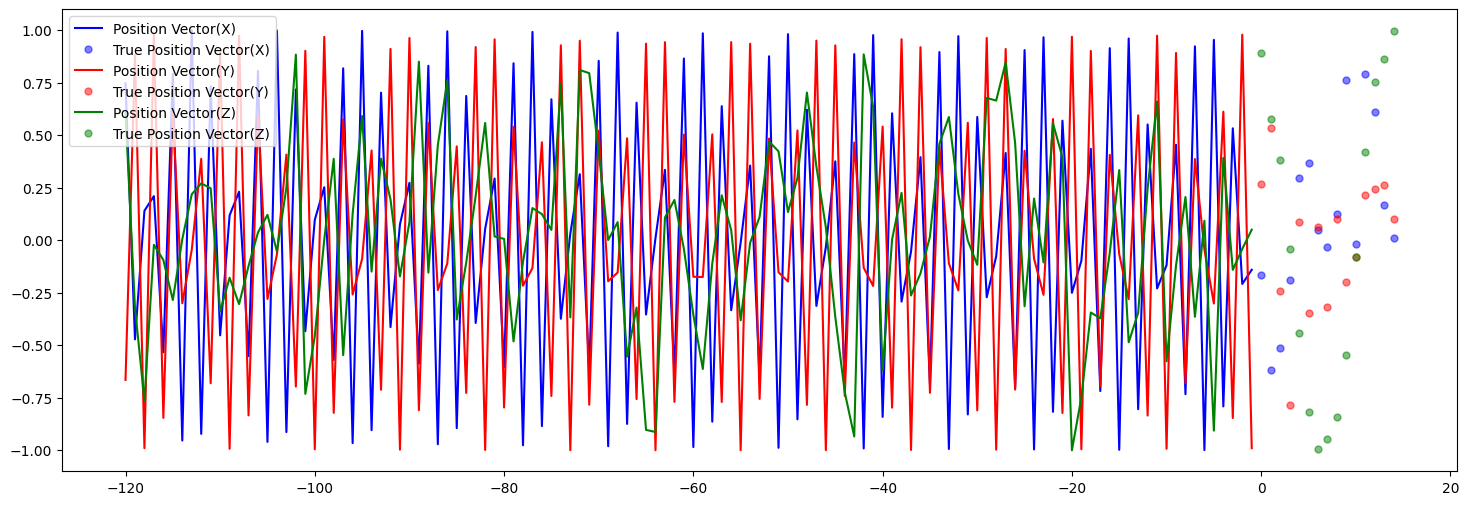

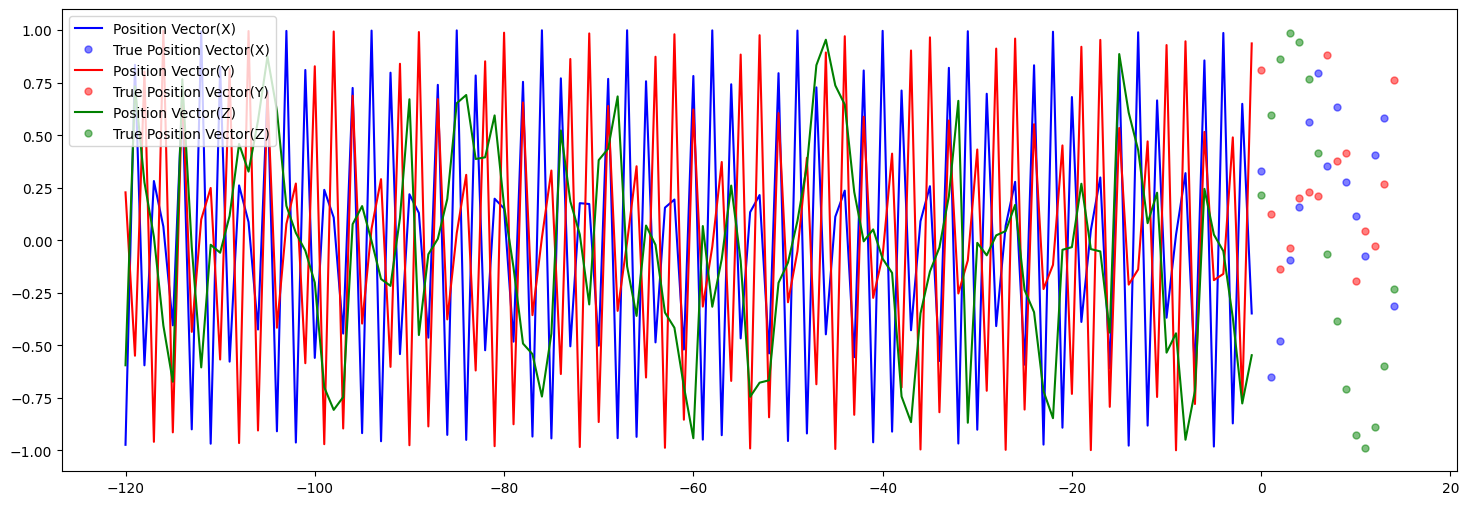

In [58]:
def create_time_steps(length):
  return list(range(-length,0))


#plotting function
def multi_step_output_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    for i, (var, c) in enumerate(zip(features.columns[2:5], ['b','r','g'])):
        plt.plot(num_in, np.array(history[:, i]), c, label=var)
        plt.plot(np.arange(num_out)/STEP, np.array(true_future[:,i]), c+'o', markersize=5, alpha=0.5,
               label=f"True {var.title()}")
        if prediction.any():
            plt.plot(np.arange(num_out)/STEP, np.array(prediction[:,i]), '*', markersize=5, alpha=0.5,
                     label=f"Predicted {var.title()}")
    
    plt.legend(loc='upper left')
    plt.show()

for x, y in train_data_multi.take(10):
    multi_step_output_plot(np.squeeze(x[0]), np.squeeze(y[0]), np.array([0]))

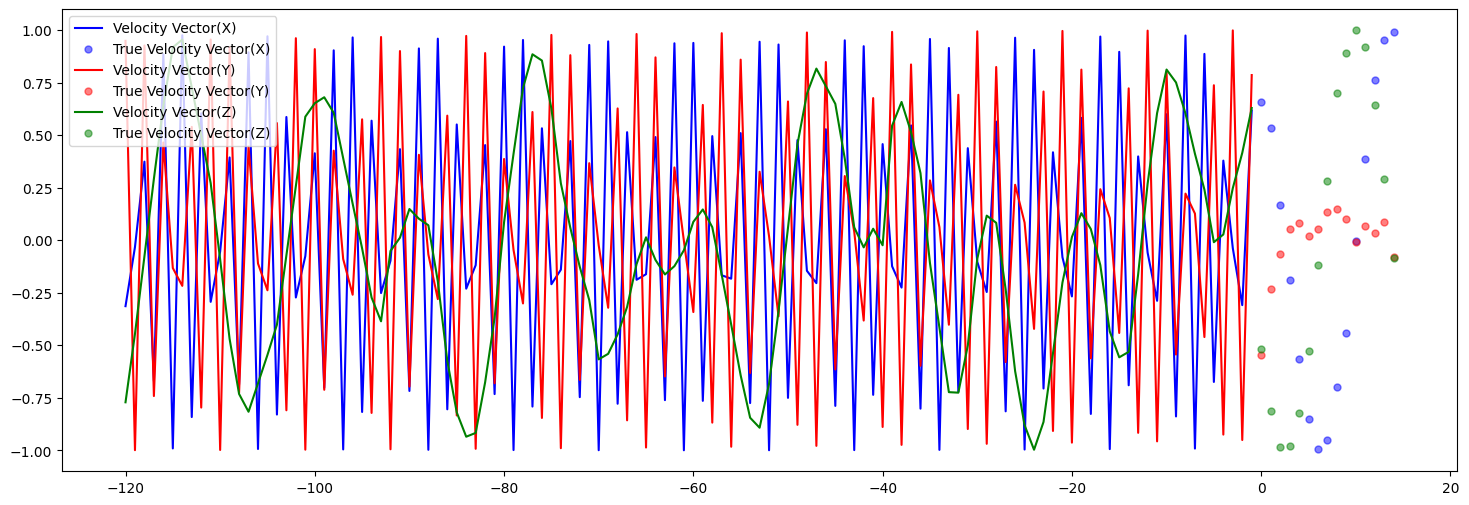

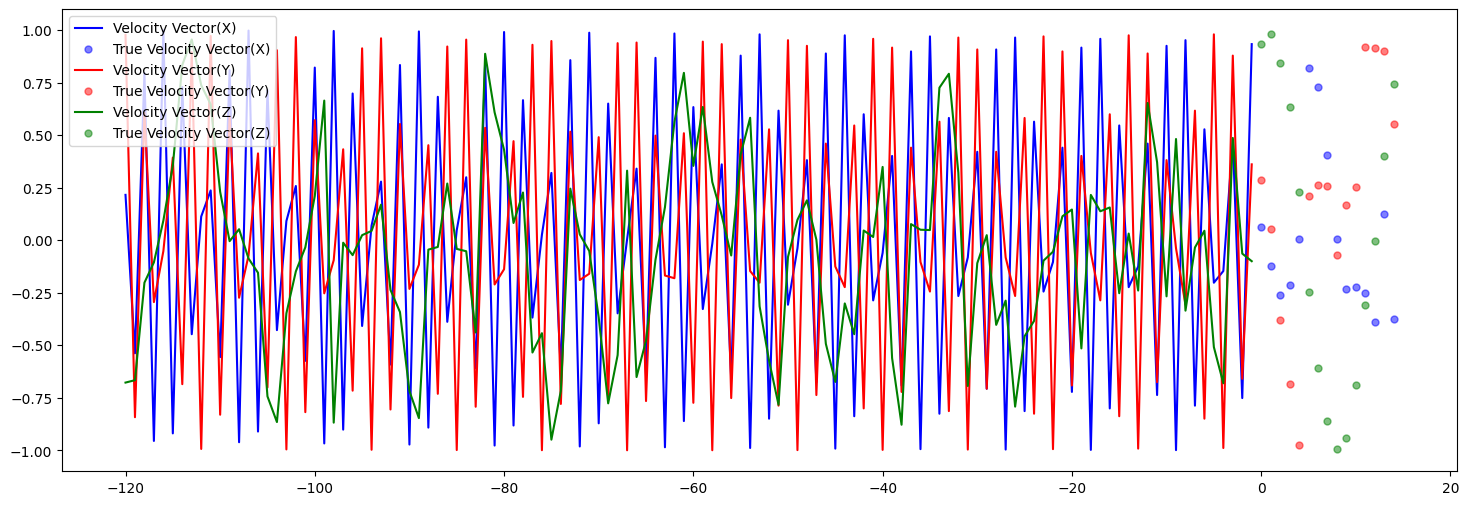

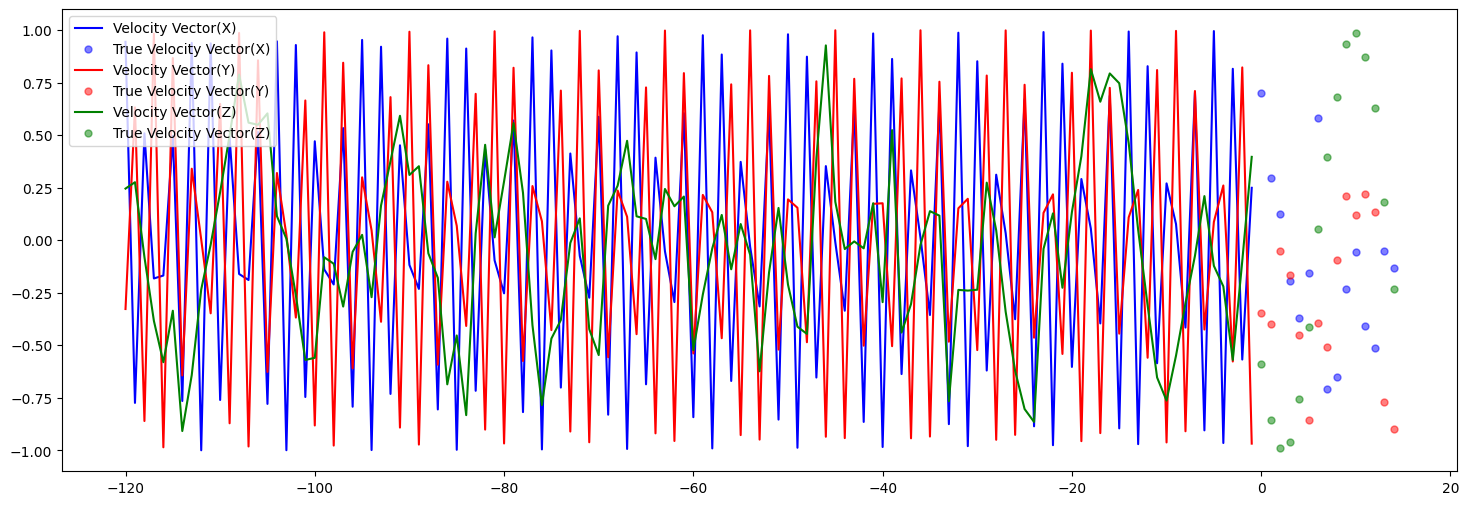

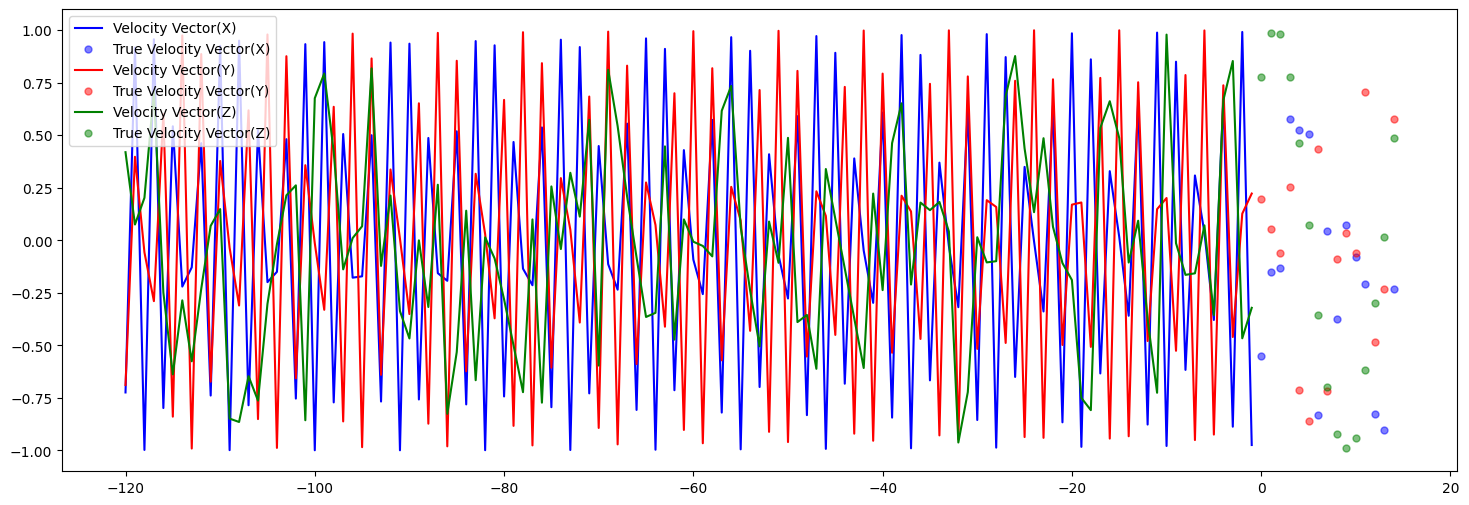

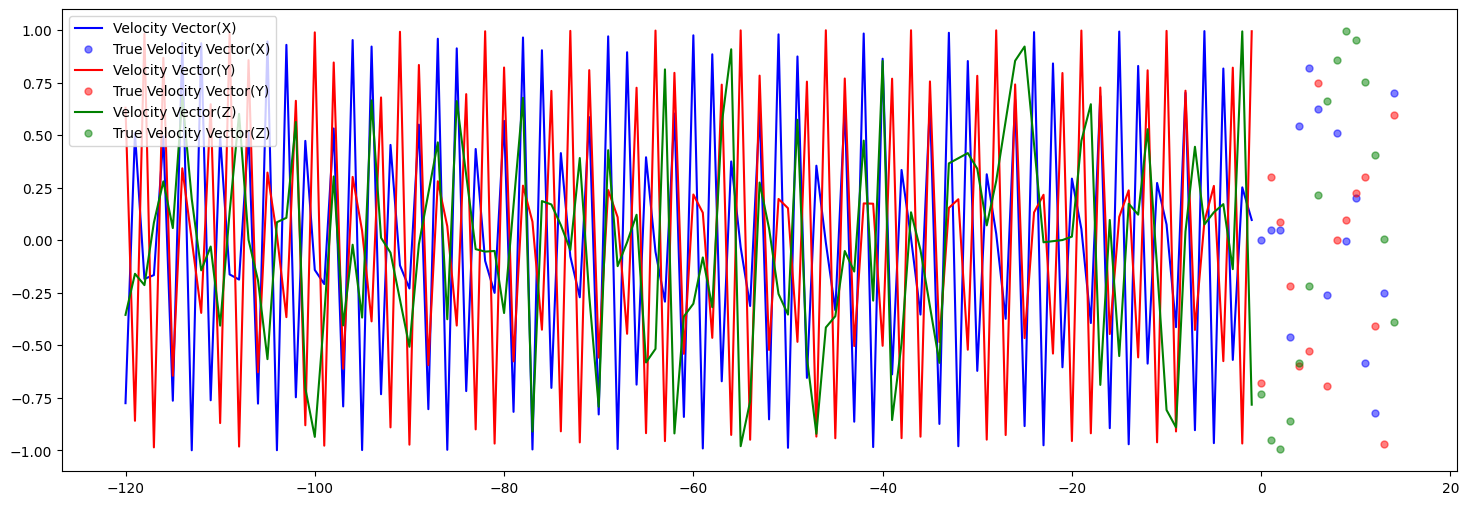

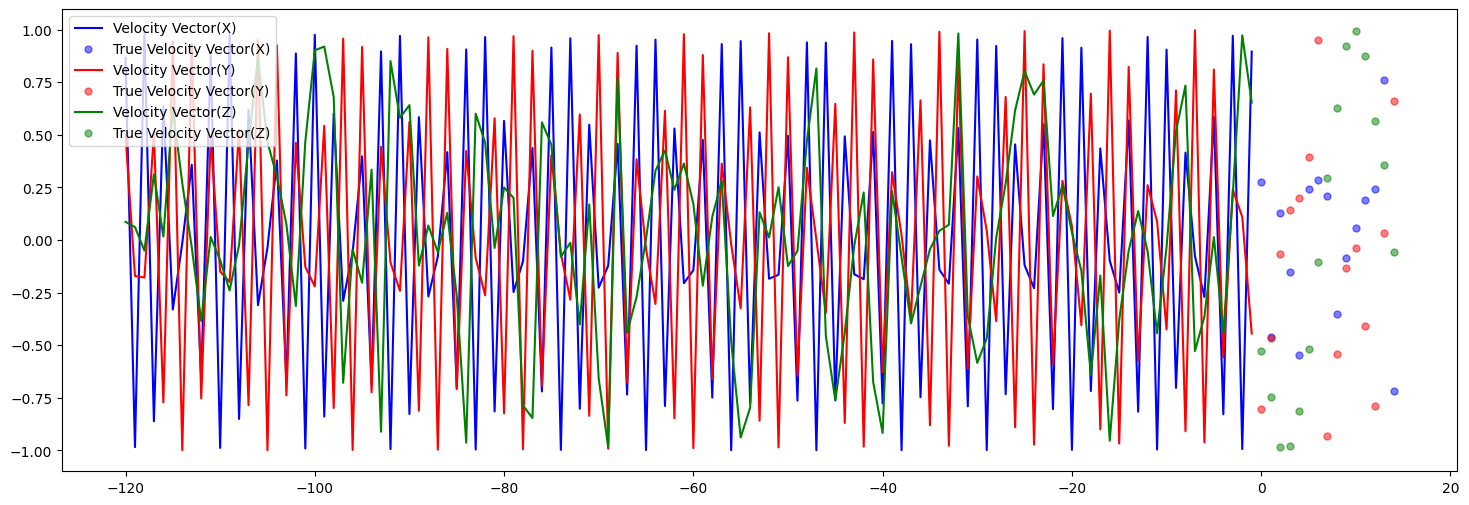

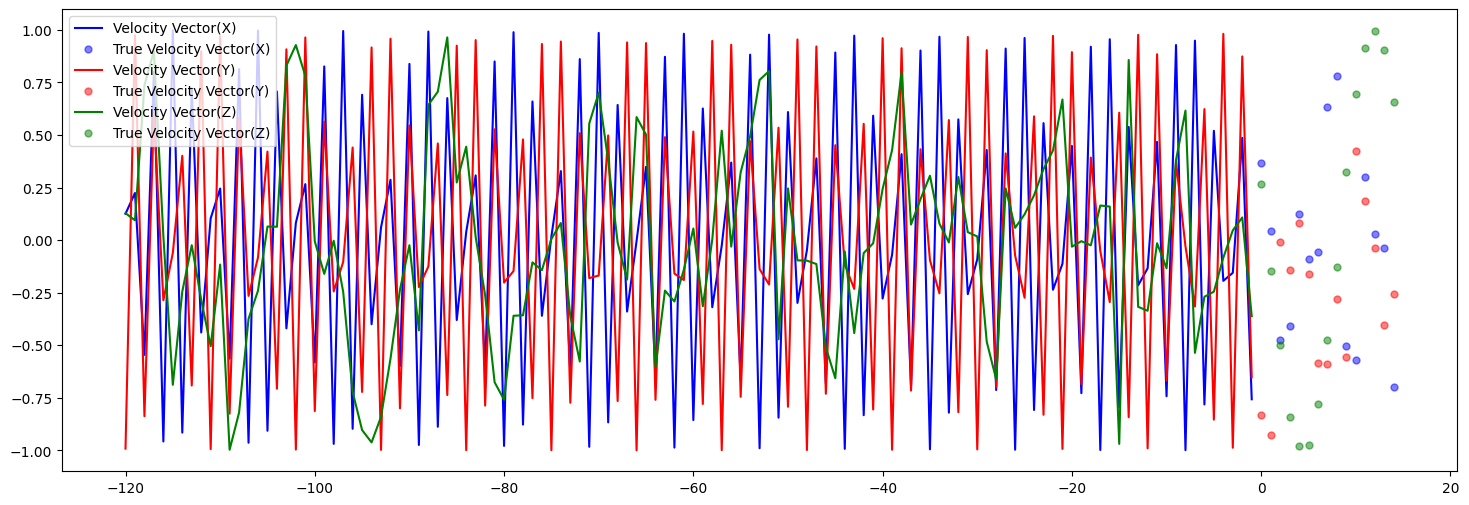

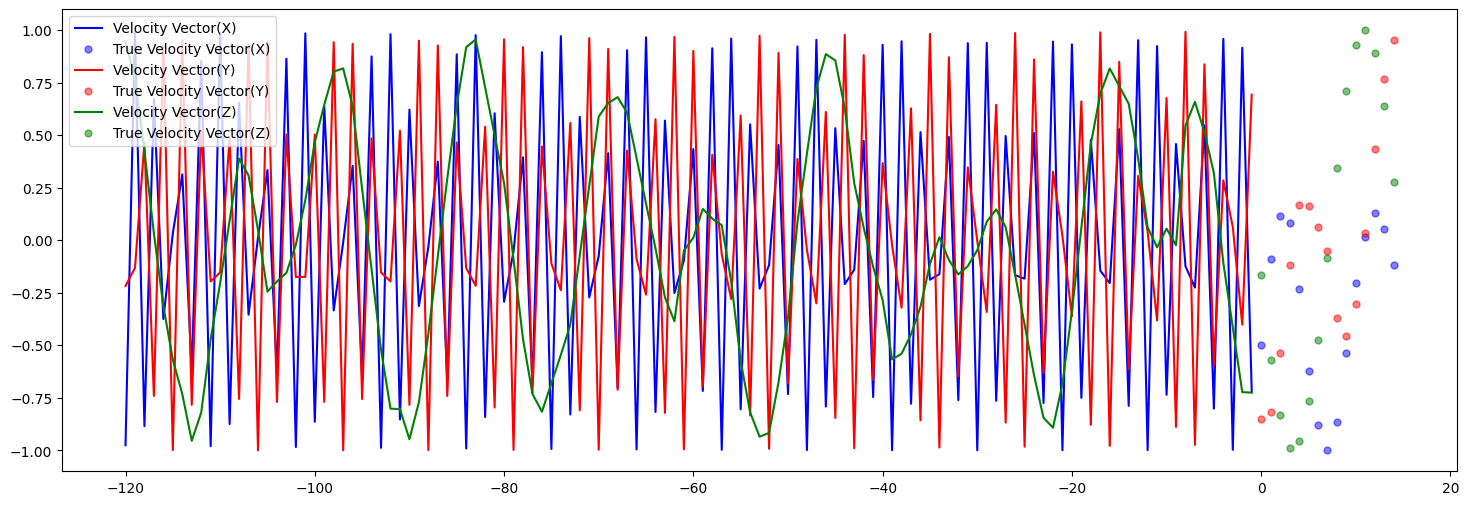

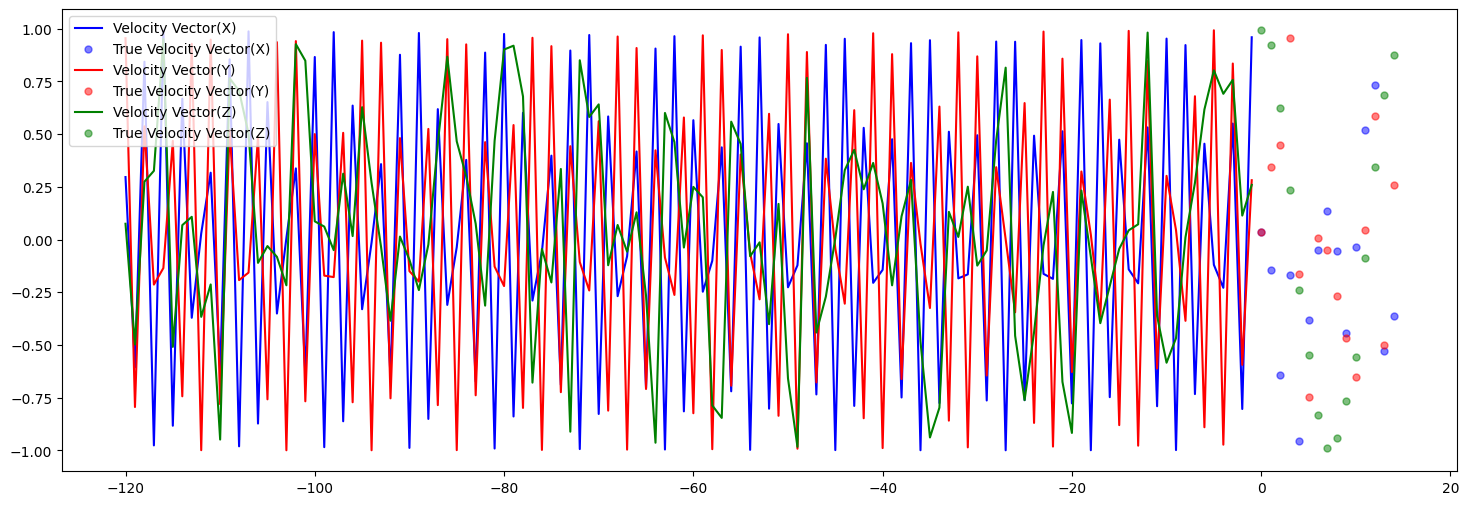

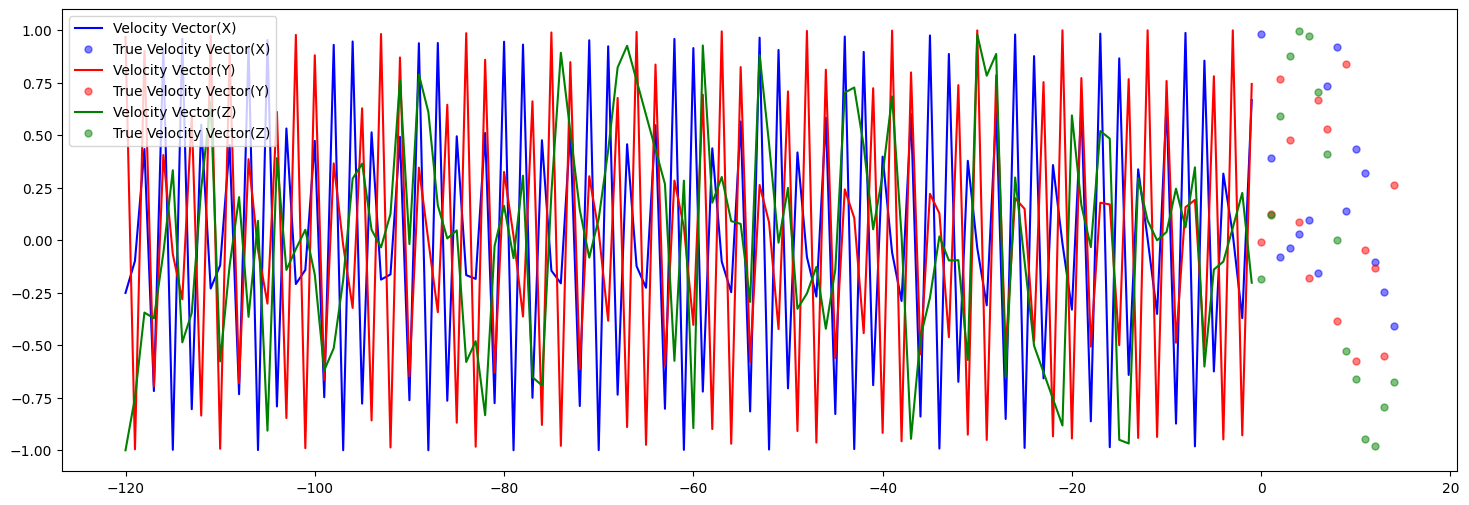

In [60]:
#plotting function
def multi_step_output_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    for i, (var, c) in enumerate(zip(features.columns[5:8], ['b','r','g'])):
        plt.plot(num_in, np.array(history[:, i]), c, label=var)
        plt.plot(np.arange(num_out)/STEP, np.array(true_future[:,i]), c+'o', markersize=5, alpha=0.5,
               label=f"True {var.title()}")
        if prediction.any():
            plt.plot(np.arange(num_out)/STEP, np.array(prediction[:,i]), '*', markersize=5, alpha=0.5,
                     label=f"Predicted {var.title()}")
    
    plt.legend(loc='upper left')
    plt.show()

for x, y in train_data_multi.take(10):
    multi_step_output_plot(np.squeeze(x[0]), np.squeeze(y[0]), np.array([0]))

